In [27]:
import numpy as np
import pandas as pd
import librosa , time, itertools, functools
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC , LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import glob, os, json, gzip, fnmatch
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from scipy import signal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from python_speech_features import mfcc, ssc
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.cluster import KMeans
from sklearn import metrics
import scikitplot as skplt

In [15]:
class LoadAudio(object):
    def __init__(self, path):
        self.path = path
        self.sample_rate = 22050
        self.labels = []
        self.ages = []
        self.data = []
    

    def read_folder(self, dir):
        audio_directions = []
        for root, _ , files in os.walk(self.path+'/'+dir):
            for filename in files:
                if fnmatch.fnmatch(filename , "*.csv") or fnmatch.fnmatch(filename , "*.xlsx"):
                    csv_direction = root+'/'+filename
                elif not fnmatch.fnmatch(filename , "*.DS_Store"):
                    audio_directions.append(root+'/'+filename)
        return csv_direction, audio_directions

    def validate(self):
        if self.csv_file.shape[1] != 3:
            return False
        return True

    def read_csv(self, dir):
        if dir.split('.',1)[1] == 'csv':
            data = pd.read_csv(dir, encoding = "ISO-8859-1", error_bad_lines=False, warn_bad_lines=False)
        else:
            data = pd.read_excel(dir, encoding = "ISO-8859-1", error_bad_lines=False)
        # for a few files that have Nan values
        data = data.dropna(thresh=3)
        data = data.dropna(axis='columns', thresh=4).values
        return data

    def get_csv_data(self):
        return list(self.csv_file[:, 0]), self.determine_gender(self.csv_file[:, 1]), self.csv_file[:, 2]

    def find_acceptable_folders(self, dir):
        available_folders = os.listdir(dir)
        acceptable_folders = set(list(map(str, self.csv_folders))).intersection(available_folders)
        return list(acceptable_folders)

    
    def get_audio_folder_index(self, direction, idx):
        indices = list(filter(lambda x: direction[x].rsplit('/', 2)[1] == idx, range(len(direction))))    
        return indices     


    def get_files(self, directions):
        audio_dir = []
        label = []
        age = []
        for f in self.acceptable_folders:
            audio_idx = self.get_audio_folder_index(directions, f)
            csv_idx = self.csv_folders.index(int(f))
            audio_dir.extend([directions[idx] for idx in audio_idx])
            [label.append(self.csv_gender[csv_idx]) for i in range(len(audio_idx))]
            [age.append(self.csv_bd[csv_idx]) for i in range(len(audio_idx))]
        return audio_dir, label, age
        


    def determine_gender(self, rows):
        gender = []
        for elem in list(map(str, rows)):
            if elem.find('F')!=-1 or elem.find('f')!=-1 or elem.find('1')!=-1:
                gender.append('Female')
            else:
                gender.append('Male')
        return gender


    def load_audio(self, x):
        y, sr = librosa.load(x, sr=self.sample_rate, duration=6)
        return y[3*sr:]

 
    def save_data(self, dir):
        l = [x.tolist() for x in self.signal]
        with gzip.GzipFile(self.path_to_save+'/'+dir+'.json', 'w') as fout:
            fout.write(json.dumps(l).encode('utf-8'))  
      

    def process_data(self):
        folders = os.listdir(self.path)
        num_of_folders_to_load = len(folders)-1

        print(f'loading {num_of_folders_to_load} folders ... \n')
        for i in range(num_of_folders_to_load):
            csv_dir, audio_dir = self.read_folder(folders[i])
            self.csv_file = self.read_csv(csv_dir)
            if not self.validate():
                print(f'reading folder {folders[i]}...\t bad data, skipping this folder\n')
                continue
            self.csv_folders, self.csv_gender, self.csv_bd = self.get_csv_data()
            self.acceptable_folders = self.find_acceptable_folders(self.path+'/'+folders[i])
            audio_file, labels, ages = self.get_files(audio_dir)
            signal = np.array(list(map(self.load_audio, audio_file)))
            self.data.extend(signal)
            self.labels.extend(labels)
            self.ages.extend(ages)
            print(f'reading folder {folders[i]}...\t ✓ \n')
        print("Done loading data \n")
        return self

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False
    , title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        plt.rcParams["figure.figsize"] = [7,7]
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        pass
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [13]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_of_ffts = 1024):
        self.sr = 22050
        self.nfft = num_of_ffts
        self.winlen = 0.015
        self.num_of_mfcc = 20
        self.num_of_ssc = 48
        self.features = None
   

    def get_mfcc(self, signal):
        mfccs = mfcc(signal, samplerate = self.sr,  winlen=self.winlen,
            numcep =self.num_of_mfcc, nfilt=2*self.num_of_mfcc, nfft=self.nfft)
        feature = np.mean(mfccs, axis=0)
        return feature

    def get_ssc(self, signal):
        sscs = ssc(signal, samplerate=self.sr, winlen=self.winlen, 
            nfilt=self.num_of_ssc, nfft=self.nfft)
        feature = np.mean(sscs, axis=0)
        return feature

    def get_feature(self, signal):
        f1 = np.array(list(map(self.get_mfcc, signal)))
        f2 = np.array(list(map(self.get_ssc, signal)))
        return np.concatenate((f1, f2), axis=1)

    def butter_bandpass(self, lowcut, highcut, fs, order):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order):
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.filtfilt(b, a, data)
        return y
    
    def filter(self):
        filtered = list(map(functools.partial(self.butter_bandpass_filter, lowcut= self.lf, 
            highcut=self.hf, fs=self.sr, order=self.order), self.signal))
      
        return filtered


    
    def fit(self, X, y=None):
        self.order = 5
        self.lf = 300
        self.hf = 8000
        return self
    
    def transform(self, X, y=None):
        self.signal = [np.array(x) for x in X]
        self.filtered_signal = self.filter()
        self.features = self.get_feature(self.filtered_signal)
        return self.features


In [14]:
def remove_bad_data(x, y, z):
    bad_data = []
    for i in range(len(x)):
        if len(x[i]) == 0:
            bad_data.append(i)
    x = np.delete(x, bad_data)
    y = np.delete(y, bad_data)
    z = np.delete(z, bad_data)
    return x,y,z

def convert_bd(birth_date):
    if len(str(birth_date)) == 2:
        birth_date = 1399 - birth_date
    return birth_date

def non_shuffling_train_test_split(X, y, z, test_size=0.25):
    i = int(test_size * X.shape[0]) 
    X_test, X_train = np.split(X, [i])
    y_test, y_train = np.split(y, [i])
    z_test, z_train = np.split(z, [i])
    return X_train, X_test, y_train, y_test, z_train, z_test

In [19]:
path_of_dataset = '/content/drive/My Drive/dataset/Data_Upload'
loader = LoadAudio(path_of_dataset).process_data()

loading 16 folders ... 

reading folder 02...	 ✓ 

reading folder 03...	 ✓ 

reading folder 05...	 ✓ 

reading folder 06...	 ✓ 

reading folder 08...	 ✓ 

reading folder 09...	 ✓ 

reading folder 12...	 ✓ 

reading folder 14...	 ✓ 

reading folder 16...	 ✓ 

reading folder 17...	 ✓ 

reading folder 01...	 bad data, skipping this folder

reading folder 04...	 bad data, skipping this folder

reading folder 07...	 ✓ 

reading folder 10...	 ✓ 

reading folder 11...	 ✓ 

reading folder 13...	 ✓ 

Done loading data 



In [42]:
data = loader.data
labels = np.array(loader.labels)
ages = np.array(loader.ages)
data = np.array(data)
encoded_label = LabelEncoder().fit_transform(labels)
ages = list(map(convert_bd, ages))

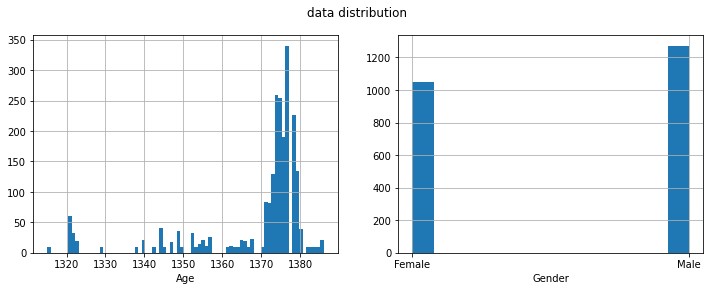

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('data distribution')

ax1.hist(x=ages, bins='auto')
ax1.grid(True)
ax1.set_xlabel('Age')

ax2.hist(x=labels, bins='auto')
ax2.grid(True)
ax2.set_xlabel('Gender')
plt.show()

In [80]:
class_names = ["Female", "Male"]
data, encoded_label, ages = remove_bad_data(data, encoded_label, ages)
X_train, X_test, y_train, y_test, age_train, age_test = non_shuffling_train_test_split(
   data, encoded_label, ages, test_size=0.25)

In [81]:
eclf = VotingClassifier(estimators=[('rf', RandomForestClassifier()), 
    ('svm', SVC(probability=True))], voting='soft')

pipe = Pipeline([('feature_extractor', FeatureExtractor()), ('scaler', StandardScaler()),
('reduce_dim', PCA()), ('feature_selector', RFE(RandomForestClassifier(),
    n_features_to_select=50)), ('clf', eclf)])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(classification_report(y_test, pred, target_names=["Female", "Male"]))
print(f'accuracy: {round(accuracy_score(y_test, pred), 2)*100}% \n')

              precision    recall  f1-score   support

      Female       0.93      0.88      0.90       319
        Male       0.86      0.92      0.89       261

    accuracy                           0.90       580
   macro avg       0.90      0.90      0.90       580
weighted avg       0.90      0.90      0.90       580

accuracy: 90.0% 



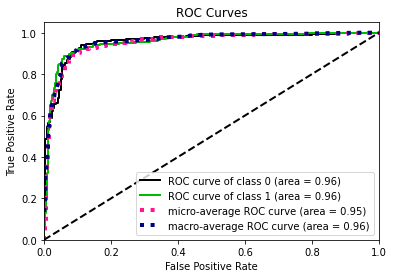

In [37]:
proba = pipe.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, proba)
plt.show()

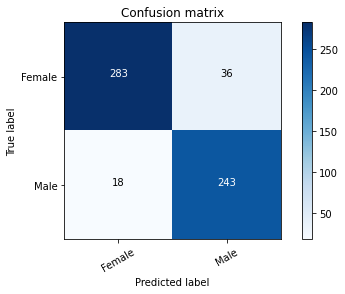

In [39]:
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=class_names, title='Confusion matrix')
plt.show()

Clustering


In [64]:
pipe = Pipeline([('feature_extractor', FeatureExtractor()), ('scaler', StandardScaler()),
('reduce_dim', PCA()), ('feature_selector', RFE(RandomForestClassifier(),
    n_features_to_select=50)), ('kmeans', KMeans(n_clusters=2))])
pipe.fit(X_test, y_test)
pred = pipe['kmeans'].labels_
indices = [np.where(pred==l)[0] for l in np.unique(pred)]
gender_dist = [labels[idx] for idx in indices]
age_dist = [ages[idx] for idx in indices]

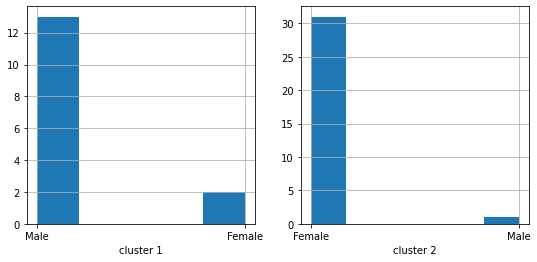

In [69]:
fig = plt.figure(figsize=(9,4))
for i in range(2):
    ax = fig.add_subplot(1,2, i + 1)
    ax.hist(x=gender_dist[i], bins='auto')
    ax.grid(True)
    ax.set_xlabel(f'cluster {i+1}')
